# Scraping protocol descriptions

### Import packages

# Setup

In [1]:
from pathlib import Path
import pickle
import pandas as pd
import requests
import numpy as np

pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 1000

In [153]:
import seaborn as sns
%matplotlib inline

In [20]:
from tabula import read_pdf


In [19]:
# Data downloaded from the following link:
link = 'https://www.in.gov/omb/2664.htm'

# Define functions

In [104]:
def get_pdf(row):
    url = row.url
    filename = row.school_name + '.pdf'
    cmd  = f"""curl {url} > 'pdfs/{filename}'"""
    !{cmd}
#     print(cmd)

def get_schools(filename,df_in,expenditure_type,unique_cols):

    useful_cols = ['year',*unique_cols]
    df_in = df_in.rename(columns = df_in.iloc[0,:])
    df_in['year']  = df_in.loc[:,df_in.apply(lambda col: bool(col.str.contains('FY.*20[0-9]{,2}').sum()))]
    df_in = (df_in
     .loc[df_in.year.notnull(),useful_cols]
     .assign(year = lambda df: df.year.str.extract('.*(20[0-9]{2,2}).*',expand=False))
     .apply(lambda col:col.str.split(" ").str[0] )
     .apply(lambda col:col.str.replace('\D',''))
     .assign(expenditure_type = expenditure_type,
            school = Path(filename).stem)

    )
    df_in = pd.melt(
        df_in,
        id_vars=[*df_in.columns.drop(useful_cols[1:])],
        value_name='amount',
        var_name = 'funding_category'
        )
    return df_in

def get_spending_breakdown(filename):

    dfs_all = read_pdf(filename,multiple_tables=True,pages=1)


    unique_cols = ['Student Academic Achievement','Student Instructional Support']
    expenditure_type = "Instructional"
    df_1 = get_schools(filename,dfs_all[0].T,expenditure_type,unique_cols)

    unique_cols = ['Overhead and Operational','Non Operational','Not Categorized']
    expenditure_type = "Non-Instructional"
    df_2 = get_schools(filename,dfs_all[1].T,expenditure_type,unique_cols)
    df_full = pd.concat([df_1,df_2], axis = 0)

    df_full
    return df_full

# Get pdfs

In [163]:
!mkdir pdfs

In [ ]:
df_pdfs = pd.read_csv('school_pdfs.csv')

df_pdfs['school_name'] = (df_pdfs
                          .school_name.str.replace('(?<!;) +?','_')
                          .str.replace(';','_')
                          .str.replace('[^a-zA-Z0-9_]','')
                         
                         )

# get_pdf(df_pdfs.iloc[1,:])
df_pdfs.apply(lambda row:get_pdf(row), axis=1)

df_pdfs['filename'] = df_pdfs.school_name.apply(lambda x: 'pdfs/' + x + '.pdf')

In [ ]:
df_pdfs.head()

# Process pdfs

In [114]:
dfs = []
bad_files = []
for filename in df_pdfs.filename:
    try:
        df_spending = get_spending_breakdown(filename)
        dfs.append(df_spending)
    except:
        bad_files.append(filename)

Error: 
Error: 
Error: 
Error: 
Error: 
Error: 


In [115]:
len(dfs)

374

Files that had broken links:

In [117]:
bad_files

['pdfs/Career_Academy_Middle_School_9965httpswwwingovombfiles9965fy16.pdf',
 'pdfs/Christel_House_DORSnbsp_9385.pdf',
 'pdfs/ombfiles3710fy16_target_blankCrothersville_Community_Schoolsnbsp_3710.pdf',
 'pdfs/Daleville_Community_Schoolsnbsp_1940.pdf',
 'pdfs/Fayette_County_School_Corpnbsp_2395.pdf',
 'pdfs/ombfilesmonrowgregg5900_target_blankMonroeGregg_School_Districtnbsp_5900.pdf']

In [118]:
df_all_schools = pd.concat(dfs,axis = 0)

In [119]:
len(df_all_schools)

11220

In [120]:
df_all_schools.to_csv('all_school_funding.csv',index=False)

# Do further analysis

In [169]:
df_all_schools = pd.read_csv('all_school_funding.csv')

df_all_schools['percentage'] = df_all_schools.groupby(['school','year'])['amount'].transform(lambda x: 100 * (x / x.sum()))

df_all_schools.sort_values(['school','year']).head()

,year,expenditure_type,school,funding_category,amount,percentage
0,2006,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,885297,35.119113
6,2006,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Instructional Support,191398,7.592625
12,2006,Non-Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Overhead and Operational,649896,25.780920
18,2006,Non-Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Non Operational,794250,31.507342
24,2006,Non-Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Not Categorized,0,0.000000


In [5]:
df_all_schools.funding_category.unique()

array(['Student Academic Achievement', 'Student Instructional Support',
       'Overhead and Operational', 'Non Operational', 'Not Categorized'],
      dtype=object)

In [5]:
fund_map = {'Student Academic Achievement':'Student spending',
            'Student Instructional Support':'Student spending',
            'Overhead and Operational': 'Overhead and Operational',
            'Non Operational': 'Non Operational',
            'Not Categorized': 'Not Categorized'}
df_all_schools['other_categories'] = df_all_schools.funding_category.apply(lambda x: fund_map[x])

In [7]:
df_all_schools.head()

,year,expenditure_type,school,funding_category,amount,percentage,other_categories
0,2006,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,885297,35.119113,Student spending
1,2009,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,1112059,74.739267,Student spending
2,2013,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,2138374,41.180753,Student spending
3,2014,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,2602899,43.344980,Student spending
4,2015,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,3740842,43.675179,Student spending


# Plot

With the charter mapping one can plot to compare:

In [163]:
df_status = pd.read_csv('charter_school_identification_docs/manual_charter_name_mapping.csv',sep='\t')
df_status = (df_status
             .assign(school_name = df_status.school_name.str.replace('-',''))
             .rename({'Comments':'status'},axis='columns')
             .iloc[:,[0,2]]
)
df_status.head()

,school_name,status
0,21st Century Charter Sch of Gary,Charter
1,Adams Central Community Schools,School District
2,Alexandria Com School Corp,School District
3,Anderson Community School Corp,School District
4,Anderson Excel Center,Adult Charter


In [164]:
df_all_schools['school_name'] = df_all_schools.school.str.split('nbsp').str[0].str.split('_[0-9]{4,10}').str[0].str.replace('_',' ')
df_all_schools.head()

,year,expenditure_type,school,funding_category,amount,percentage,other_categories,charter_status,school_name
0,2006,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,885297,35.119113,Student spending,True,21st Century Charter Sch of Gary
1,2009,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,1112059,74.739267,Student spending,True,21st Century Charter Sch of Gary
2,2013,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,2138374,41.180753,Student spending,True,21st Century Charter Sch of Gary
3,2014,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,2602899,43.344980,Student spending,True,21st Century Charter Sch of Gary
4,2015,Instructional,21st_Century_Charter_Sch_of_Garynbsp_9545,Student Academic Achievement,3740842,43.675179,Student spending,True,21st Century Charter Sch of Gary


In [165]:
df_merge = df_all_schools.merge(df_status, on = 'school_name',how= 'left')
df_merge.status.isnull().sum()

0

# problem schools

In [166]:
(df_all_schools.
 query('percentage.isnull()').
 sort_values(['school','year','funding_category']).
 to_csv('possible_missing_data.csv',index=False)

In [155]:
len(df_all_schools.query('percentage.isnull()').school.unique())

65

Data does not exist for these schools in these years because they were not yet open.

# plot

/Users/emilylanghorne/miniconda3/envs/juplab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


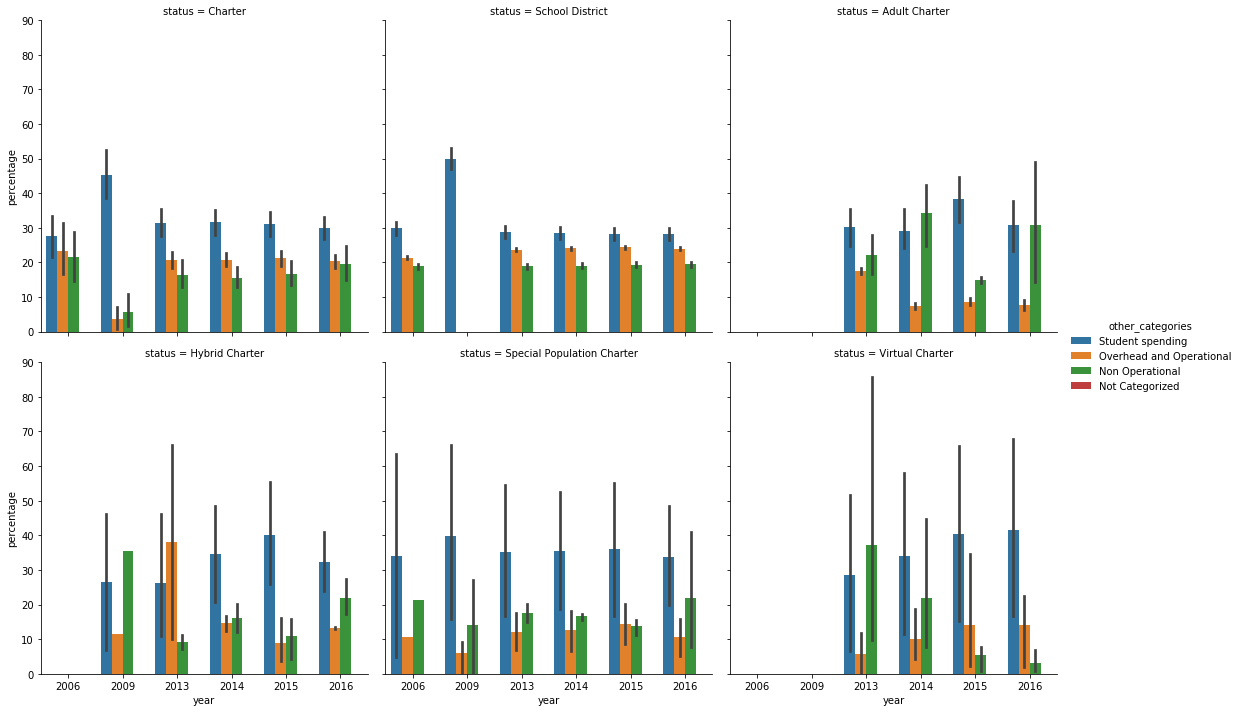

In [176]:
ax = sns.catplot(x="year", y="percentage",
                 hue="other_categories",
                 col = 'status',
                 col_wrap =3,
                 kind = 'bar',
                 data=df_merge.query("(percentage.notnull()) and not status == 'REMOVE'"))
ax.savefig("barplot_faceted_across_school_type.png")

## Boxplot instead to get a better sense of the distribution

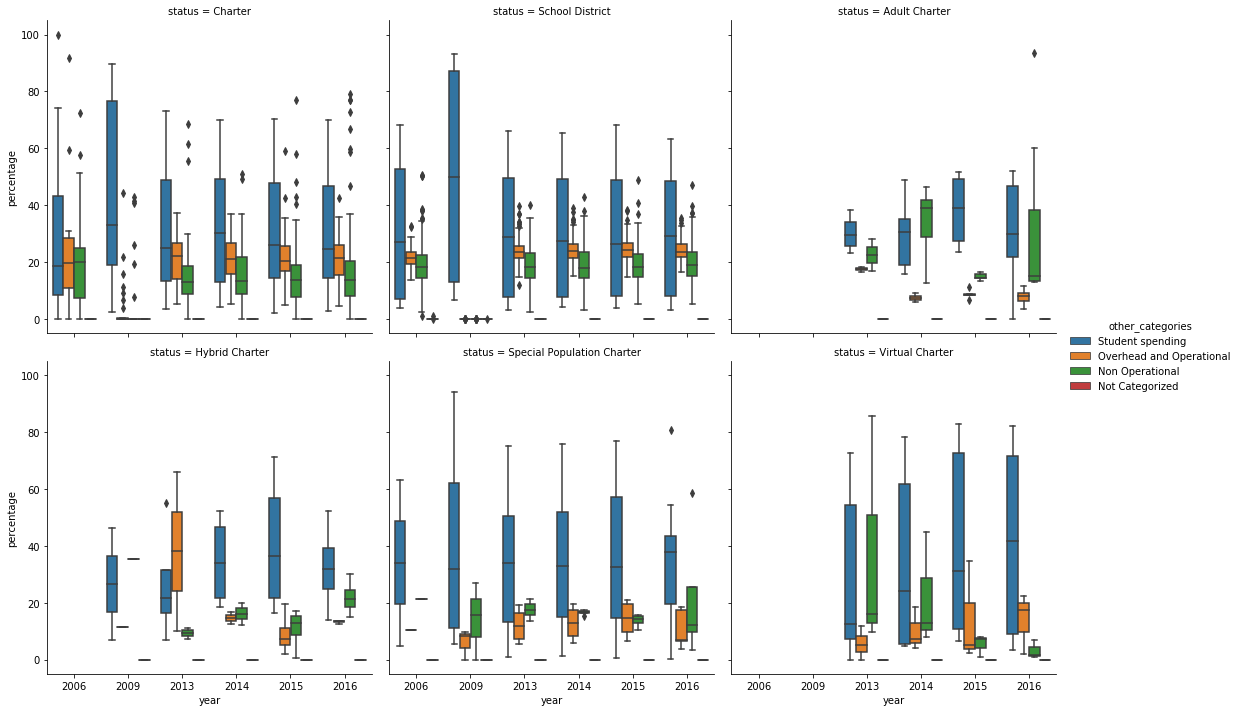

In [177]:
ax = sns.catplot(x="year", y="percentage",
                 hue="other_categories",
                 col = 'status',
                 col_wrap =3,
                 kind = 'box',
                 data=df_merge.query("(percentage.notnull()) and not status == 'REMOVE'"))
ax.savefig("boxplot_faceted_across_school_type.png")

# Compare each funding category expenditure across the school types

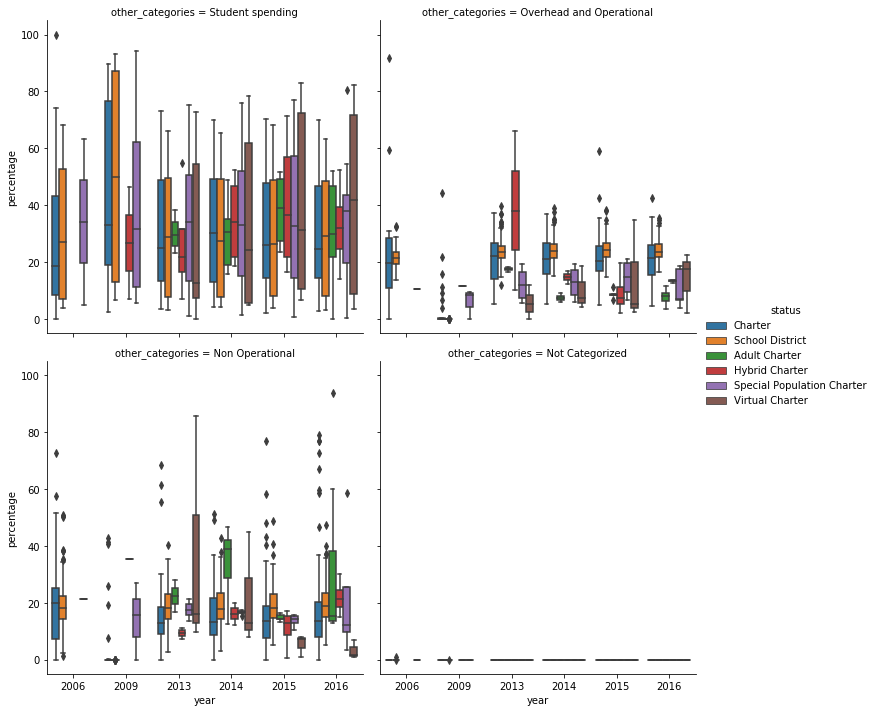

In [178]:
ax = sns.catplot(x="year", y="percentage",
                 col="other_categories",
                 hue = 'status',
                 col_wrap =2,
                 kind = 'box',
                 data=df_merge.query("(percentage.notnull()) and not status == 'REMOVE'"))
ax.savefig("barplot_faceted_across_funding_category.png")